In [1]:
!pip install Darts

  Obtaining dependency information for Darts from https://files.pythonhosted.org/packages/0b/29/3d09769040517fe39c2b16c3445a9d88d1290e88ba67a9a08a7071efafce/darts-0.26.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.4 MB/s eta 0:00:00
  Obtaining dependency information for holidays>=0.11.1 from https://files.pythonhosted.org/packages/0e/6d/8a673d26d687486aac3b2b77faaa9fe5f452cadc2fc586081ddeda3b5140/holidays-0.33-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.2/579.2 kB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for shap>=0.40.0 from https://files.pythonhosted.org/packages/45/b9/99ca52bf4442ec9506534d59ec74db5fb45a9bb6430a4fd4781120a249d1/shap-0.42.1-cp310-cp310-macosx_11_0_arm64.whl

**Import Darts**

In [39]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [40]:
# multiprocessing
from joblib import Parallel, delayed

# data manipulation
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler

# models
from darts.models import NaiveSeasonal, StatsForecastAutoARIMA, ExponentialSmoothing, Prophet #local
from darts.models import LightGBMModel, RNNModel, NBEATSModel, TFTModel #global

# likelihood
from darts.utils.likelihood_models import GaussianLikelihood

# evaluation
from darts.metrics import mape

# settings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [41]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('../raw_data/00/sorted_feature_matrix.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [33]:
df

,Date,Dividend,Volume,stock_price,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma
0,2018-01-31,0.00,5.315047e+06,51.919825,1.41,4500.182000,AAL,-134.253165,0.807713,-0.941772,0.484585,0.476713,1.930838,0.285655,5.198588e-01,1.944860e-01
1,2018-01-31,0.00,1.795523e+08,40.275178,1.41,4500.182000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.222114,6.974815e-01,8.040471e-02
2,2018-01-31,0.71,7.794467e+06,87.747239,1.41,4500.182000,ABBV,-23.651147,1.818001,-0.940431,1.083967,0.657965,1.027436,0.351660,3.990092e-01,2.493303e-01
3,2018-01-31,0.28,7.860137e+06,54.655791,1.41,4500.182000,ABT,1.333073,0.319962,0.018336,1.128287,0.829424,0.837345,0.323488,5.800269e-01,9.648529e-02
4,2018-01-31,0.00,1.614810e+06,29.889667,1.41,4500.182000,ACGL,2.331811,0.564373,0.024308,0.679544,0.278000,0.000000,0.000003,1.541489e-05,9.999820e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32909,2023-09-30,0.00,2.114983e+06,133.590376,5.08,5105.025000,YUM,-1.693220,1.487544,-0.049550,0.721587,0.427386,0.938914,0.008204,4.912204e-01,5.005759e-01
32910,2023-09-30,0.00,1.614090e+06,135.349948,5.08,5105.025000,ZBH,0.720673,1.004794,0.016942,0.945561,0.834571,0.230908,0.499998,5.000007e-01,1.404991e-06
32911,2023-09-30,0.00,3.709700e+05,274.414666,5.08,5053.623333,ZBRA,1.491979,2.802807,0.048128,0.502260,0.854987,0.732639,0.999969,2.603792e-05,5.176677e-06
32912,2023-09-30,0.00,5.042810e+06,28.125514,5.08,5105.025000,ZION,15.511452,1.181283,0.033125,0.458553,0.388889,-17.000000,1.000000,2.596820e-07,6.590589e-08


In [5]:
label_encoder = LabelEncoder()

# Encode the ticker column
df['ticker_encoded'] = label_encoder.fit_transform(df['Tickers'])
df

,Date,Dividend,Volume,stock_price,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma,ticker_encoded
0,2018-01-31,0.00,5.315047e+06,51.919825,1.41,4500.182000,AAL,-134.253165,0.807713,-0.941772,0.484585,0.476713,1.930838,0.285655,5.198588e-01,1.944860e-01,1
1,2018-01-31,0.00,1.795523e+08,40.275178,1.41,4500.182000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.222114,6.974815e-01,8.040471e-02,2
2,2018-01-31,0.71,7.794467e+06,87.747239,1.41,4500.182000,ABBV,-23.651147,1.818001,-0.940431,1.083967,0.657965,1.027436,0.351660,3.990092e-01,2.493303e-01,3
3,2018-01-31,0.28,7.860137e+06,54.655791,1.41,4500.182000,ABT,1.333073,0.319962,0.018336,1.128287,0.829424,0.837345,0.323488,5.800269e-01,9.648529e-02,4
4,2018-01-31,0.00,1.614810e+06,29.889667,1.41,4500.182000,ACGL,2.331811,0.564373,0.024308,0.679544,0.278000,0.000000,0.000003,1.541489e-05,9.999820e-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32909,2023-09-30,0.00,2.114983e+06,133.590376,5.08,5105.025000,YUM,-1.693220,1.487544,-0.049550,0.721587,0.427386,0.938914,0.008204,4.912204e-01,5.005759e-01,477
32910,2023-09-30,0.00,1.614090e+06,135.349948,5.08,5105.025000,ZBH,0.720673,1.004794,0.016942,0.945561,0.834571,0.230908,0.499998,5.000007e-01,1.404991e-06,478
32911,2023-09-30,0.00,3.709700e+05,274.414666,5.08,5053.623333,ZBRA,1.491979,2.802807,0.048128,0.502260,0.854987,0.732639,0.999969,2.603792e-05,5.176677e-06,479
32912,2023-09-30,0.00,5.042810e+06,28.125514,5.08,5105.025000,ZION,15.511452,1.181283,0.033125,0.458553,0.388889,-17.000000,1.000000,2.596820e-07,6.590589e-08,480


In [41]:
df.columns

Index(['Date', 'Dividend', 'Volume', 'stock_price', 'fed_funds_rate', 'GDP',
       'Tickers', 'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
       'operating_ratio', 'inventory_turnover', 'pos_ma', 'neu_ma', 'neg_ma',
       'ticker_encoded'],
      dtype='object')

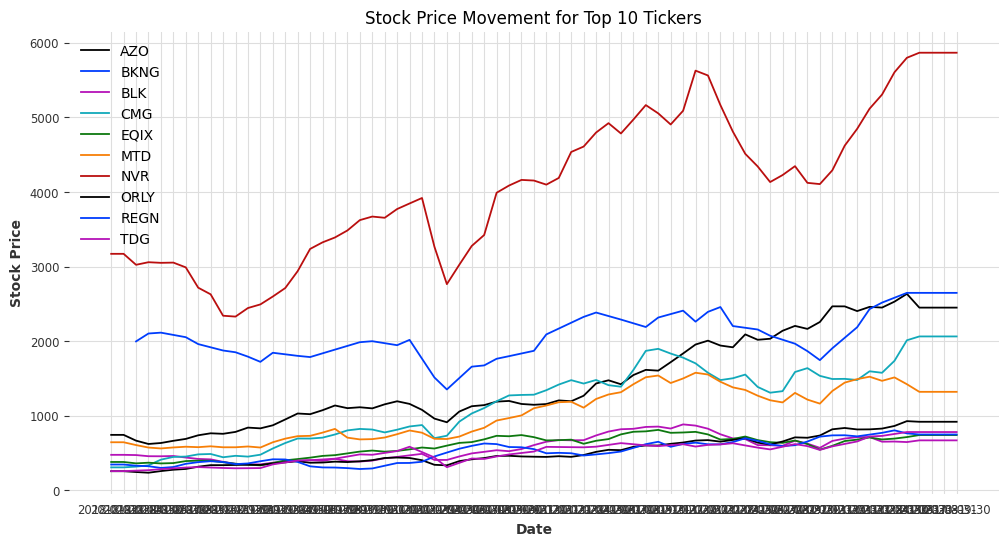

In [72]:
top_tickers = (
    df.groupby('Tickers')
    .agg({'stock_price': 'mean'})
    .sort_values(by='stock_price', ascending=False)
    .head(10)
    .index
)
data_top_tickers = df[df['Tickers'].isin(top_tickers)]
plt.figure(figsize=(12, 6))
for ticker, group in data_top_tickers.groupby('Tickers'):
    plt.plot(group['Date'], group['stock_price'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Movement for Top 10 Tickers')
plt.legend()
plt.grid(True)
plt.show()

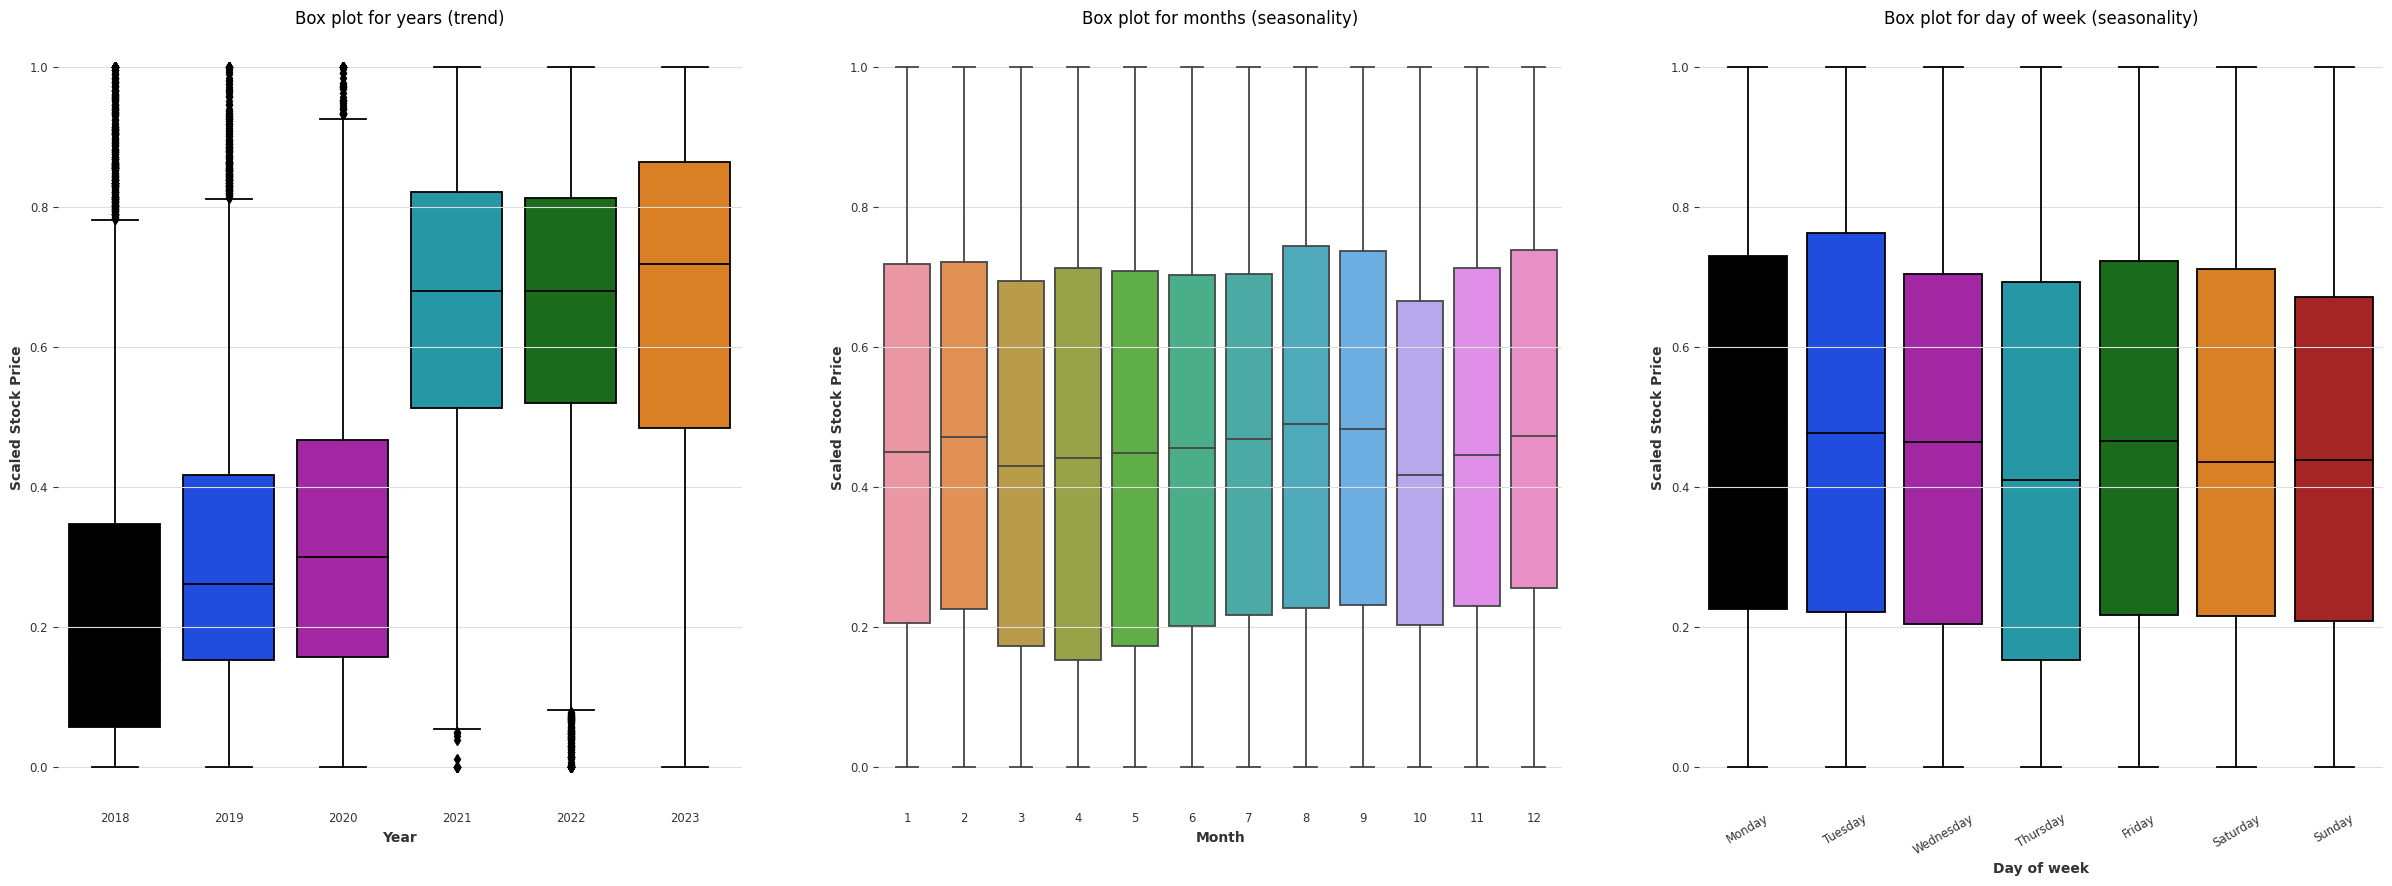

In [75]:
# make copy of df
dataset_scaled_EDA = df.copy()
dataset_scaled_EDA['Date'] = pd.to_datetime(dataset_scaled_EDA['Date'])

# min max value calculation
dataset_scaled_EDA['min_stock_price'] = dataset_scaled_EDA.groupby(['Tickers'])['stock_price'].transform(lambda x: x.min())
dataset_scaled_EDA['max_stock_price'] = dataset_scaled_EDA.groupby(['Tickers'])['stock_price'].transform(lambda x: x.max())
# scale
dataset_scaled_EDA['stock_price_scaled'] = (dataset_scaled_EDA['stock_price'] - dataset_scaled_EDA['min_stock_price'])/(dataset_scaled_EDA['max_stock_price'] - dataset_scaled_EDA['min_stock_price'])
# add info about year, week of year and day of week
dataset_scaled_EDA['year'] = dataset_scaled_EDA['Date'].dt.year
dataset_scaled_EDA['month'] = dataset_scaled_EDA['Date'].dt.month
dataset_scaled_EDA['day_of_week'] = [d.strftime('%A') for d in dataset_scaled_EDA['Date']]
dataset_scaled_EDA['day_of_week'] = pd.Categorical(dataset_scaled_EDA['day_of_week'], 
  categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
  ordered=True)

# visualize
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
sns.boxplot(x='year', y='stock_price_scaled', data=dataset_scaled_EDA, ax=ax[0]).set(
    xlabel='Year', 
    ylabel='Scaled Stock Price'
)
ax[0].set_title('Box plot for years (trend)')
sns.boxplot(x='month', y='stock_price_scaled', data=dataset_scaled_EDA, ax=ax[1]).set(
    xlabel='Month', 
    ylabel='Scaled Stock Price'
)
ax[1].set_title('Box plot for months (seasonality)')
sns.boxplot(x='day_of_week', y='stock_price_scaled', data=dataset_scaled_EDA, ax=ax[2]).set(
    xlabel='Day of week', 
    ylabel='Scaled Stock Price'
)
ax[2].set_title('Box plot for day of week (seasonality)')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=30)
plt.show()

**Create TimeSeries object and save in list (required by models in Darts)**

In [60]:
dataset_ts = df.copy()
value_cols = ['Dividend', 'Volume', 'stock_price', 'fed_funds_rate', 'GDP',
              'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
              'operating_ratio', 'inventory_turnover', 'pos_ma', 'neu_ma', 'neg_ma']
dataset_ts = TimeSeries.from_group_dataframe(df=dataset_ts, 
                                             group_cols=['Tickers'],
                                             time_col='Date', 
                                             value_cols=value_cols)

In [64]:
tickers_list = df['Tickers'].unique()

In [67]:
family_TS_dict = {}

for ticker in tickers_list:
  df_family = df.loc[df['ticker_encoded'] == ticker]

  list_of_TS_family = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="Date",
                                group_cols=["ticker_encoded"],  # individual time series are extracted by grouping `df` by `group_cols`
                                # static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
                                value_cols="stock_price", # target variable
                                fill_missing_dates=True,
                                freq='M')
  for ts in list_of_TS_family:
            ts = ts.astype(np.float32)

  list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
  family_TS_dict[ticker] = list_of_TS_family

In [68]:
# Create TimeSeries objects (Darts) 1782

list_of_TS = TimeSeries.from_group_dataframe(
                                df,
                                time_col="Date",
                                group_cols=["ticker_encoded"],  # individual time series are extracted by grouping `df` by `group_cols`
                                # static_cols=["city","state","type","cluster"], # also extract these additional columns as static covariates
                                value_cols="stock_price", # target variable
                                fill_missing_dates=True,
                                freq='M')
for ts in list_of_TS:
            ts = ts.astype(np.float32)

list_of_TS = sorted(list_of_TS, key=lambda ts: int(ts.static_covariates_values()[0,0]))

In [71]:
def flatten(l):
    return [item for sublist in l for item in sublist]

future_covariates_full = []

for ticker in tickers_list:
    future_covariates_full.append(future_covariates_dict[ticker])

future_covariates_full = flatten(future_covariates_full)

NameError: name 'future_covariates_dict' is not defined

**Problems with multiple series:**

1. may miss details, such as anomalies, 
2. perhaps should not process each time series in the same way.
3. typical problems: missing data, data drift, and rare events (black swans).

More series can potentially help us because the model will be able to use more data, and therefore there will be more representative observations for a particular pattern.

**Multivariate vs. Multiple Time Series**

Multivariate: 
- time series are from a single process, are interconnected, correlated, and interact with each other.
- Considers all the stock prices together as a single multivariate time series.
- Uses historical data of all stocks to forecast their future prices simultaneously, taking into account potential interdependencies or correlations between the stock prices.
- produce predictions for all tickers simultaneously as part of the multivariate forecast.
- won't provide individual ticker-specific stock price predictions in isolation from the other tickers.
- provides forecasts for all tickers together, considering their potential interdependencies

Multiple: 
- treat each stock price as an independent time series.
- build separate forecasting models for each stock, considering only its own historical data.
- assumes no interdependencies or correlations between the stock prices and treats them as unrelated.
- individual stock price forecasts and do not consider them to be related
- obtain individual ticker-specific stock price predictions

In [8]:
df1=df.copy()
# Add a unique identifier column for each combination of Ticker and Date
df1['Unique_ID'] = df1.groupby(['Tickers', 'Date']).ngroup()

# Define the columns you want to include in the multivariate time series
value_cols = ['Dividend', 'Volume', 'stock_price', 'fed_funds_rate', 'GDP',
              'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
              'operating_ratio', 'inventory_turnover', 'pos_ma', 'neu_ma', 'neg_ma']

# Pivot the DataFrame to create a multivariate time series
multivariate_series = df.pivot(index='Date', columns='Tickers', values=value_cols)


In [91]:
multivariate_series

Dividend                                                         \
Tickers           A  AAL    AAPL  ABBV   ABT ACGL   ACN ADBE    ADI    ADM   
Date                                                                         
2018-01-31      NaN  0.0  0.0000  0.71  0.28  0.0  0.00  0.0    NaN  0.000   
2018-02-28   0.0000  0.1  0.1575  0.00  0.00  0.0  0.00  0.0  0.000  0.335   
2018-03-31   0.0000  0.0  0.0000  0.00  0.00  0.0  0.00  0.0  0.384  0.000   
2018-04-30   0.1490  0.0  0.0000  0.96  0.28  0.0  1.33  0.0  0.000  0.000   
2018-05-31   0.0000  0.1  0.1825  0.00  0.00  0.0  0.00  0.0  0.000  0.335   
...             ...  ...     ...   ...   ...  ...   ...  ...    ...    ...   
2023-05-31   0.0000  0.0  0.2400  0.00  0.00  0.0  0.00  0.0  0.000  0.450   
2023-06-30   0.1125  0.0  0.0000  0.00  0.00  0.0  0.00  0.0  0.430  0.000   
2023-07-31   0.0000  0.0  0.0000  1.48  0.51  0.0  1.12  0.0  0.000  0.000   
2023-08-31   0.0000  0.0  0.0000  0.00  0.00  0.0  0.00  0.0  0.000  0.000   
2023-09-30   0.0000  0.0  0.0000  0.00  0.00  0.0  0.00  0.0  0.000  0.000   

            ...        neg_ma                                                  \
Tickers     ...          WYNN           XEL       XOM      XRAY           XYL   
Date        ...                                                                 
2018-01-31  ...  7.820502e-03  1.503411e-04  0.077462  0.138637  1.194629e-01   
2018-02-28  ...  1.336066e-05  4.692189e-07  0.187740  0.106750  1.174873e-05   
2018-03-31  ...  8.333690e-07  4.408431e-05  0.079787  0.107042  1.604409e-06   
2018-04-30  ...  6.655623e-05  4.804350e-05  0.099378  0.251238  1.604409e-06   
2018-05-31  ...  3.896794e-05  4.804350e-05  0.073613  0.019688  6.557487e-06   
...         ...           ...           ...       ...       ...           ...   
2023-05-31  ...  1.040856e-07  9.388031e-03  0.329222  0.025153  2.005693e-07   
2023-06-30  ...  1.320341e-01  7.188763e-04  0.000441  0.000006  2.015084e-02   
2023-07-31  ...  8.129173e-03  2.361396e-03  0.000001  0.143079  1.789569e-01   
2023-08-31  ...  3.069017e-02  1.850166e-01  0.004738  0.427556  1.973353e-01   
2023-09-30  ...  4.976273e-01  5.234888e-03  0.499864  0.037201  5.287511e-01   

                                                                      
Tickers          YUM       ZBH          ZBRA          ZION       ZTS  
Date                                                                  
2018-01-31  0.000371  0.096485  8.545747e-07  9.631739e-05  0.008634  
2018-02-28  0.000005  0.036495  1.211151e-03  1.981682e-08  0.000021  
2018-03-31  0.038324  0.013717  2.585805e-04  1.166238e-08  0.000002  
2018-04-30  0.010004  0.112134  2.585805e-04  2.053099e-08  0.000145  
2018-05-31  0.000684  0.028357  1.802918e-05  2.300701e-06  0.000004  
...              ...       ...           ...           ...       ...  
2023-05-31  0.000196  0.004817  8.549383e-01  5.939009e-02  0.000010  
2023-06-30  0.017225  0.002126  5.234137e-07  7.965156e-05  0.058278  
2023-07-31  0.000194  0.008652  5.234137e-07  2.134673e-04  0.007465  
2023-08-31  0.032084  0.000003  1.264666e-02  2.837348e-02  0.333404  
2023-09-30  0.500576  0.000001  5.176677e-06  6.590589e-08  0.000010  

[69 rows x 6748 columns]

In [93]:
# Create a darts TimeSeries object from the pivot table
multivariate_series.index = pd.to_datetime(multivariate_series.index)
multivariate_series = TimeSeries.from_dataframe(multivariate_series,   
                                                freq='M')

In [95]:
scaler = Scaler()
scaled_series = scaler.fit_transform(multivariate_series)

# PyTorch Forecasting

In [97]:
!pip install lightning
!pip install pytorch_forecasting

  Obtaining dependency information for lightning from https://files.pythonhosted.org/packages/2f/90/2a2bc44409df179e3959209c2b16b4dab438a116fdd0b52470a0e2f1f0be/lightning-2.0.9-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.3 MB/s eta 0:00:00
  Obtaining dependency information for click<10.0 from https://files.pythonhosted.org/packages/00/2e/d53fa4befbf2cfa713304affc7ca780ce4fc1fd8710527771b58311a3229/click-8.1.7-py3-none-any.whl.metadata
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Obtaining dependency information for croniter<1.5.0,>=1.3.0 from https://files.pythonhosted.org/packages/f2/91/e5ae454da8200c6eb6cf94ca05d799b51e2cb2cc458a7737aebc0c5a21bb/croniter-1.4.1-py2.py3-none-any.whl.metadata
  Using cached croniter-1.4.1-py2.py3-none-any.whl.metadata (24 kB)
  Obtaining dependency information for deepdiff<8.0,>=5.7.0 from https://files.pythonhosted.org/packages/0a/aa/ad75c66354a1b3619e73879a48219488e5ea91f26569d2f1fd4ba616c

In [45]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 995.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 1.3 MB/s eta 0:00:0000:0100:010m


In [55]:
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu


In [56]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [57]:
import torch
import math

# check if PyTorch has access to GPU
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [46]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [47]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [243]:
# convert Date column into DateTime and set as integer index in chronological order
df_pytorch = df.copy()
df_pytorch['Date'] = pd.to_datetime(df1['Date'])
df_pytorch['time_idx'] = df_pytorch.groupby('Tickers').cumcount()
df_pytorch

,Date,Dividend,Volume,stock_price,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma,ticker_encoded,time_idx
0,2018-01-31,0.00,5.315047e+06,51.919825,1.41,4500.182000,AAL,-134.253165,0.807713,-0.941772,0.484585,0.476713,1.930838,0.285655,5.198588e-01,1.944860e-01,1,0
1,2018-01-31,0.00,1.795523e+08,40.275178,1.41,4500.182000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.222114,6.974815e-01,8.040471e-02,2,0
2,2018-01-31,0.71,7.794467e+06,87.747239,1.41,4500.182000,ABBV,-23.651147,1.818001,-0.940431,1.083967,0.657965,1.027436,0.351660,3.990092e-01,2.493303e-01,3,0
3,2018-01-31,0.28,7.860137e+06,54.655791,1.41,4500.182000,ABT,1.333073,0.319962,0.018336,1.128287,0.829424,0.837345,0.323488,5.800269e-01,9.648529e-02,4,0
4,2018-01-31,0.00,1.614810e+06,29.889667,1.41,4500.182000,ACGL,2.331811,0.564373,0.024308,0.679544,0.278000,0.000000,0.000003,1.541489e-05,9.999820e-01,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32909,2023-09-30,0.00,2.114983e+06,133.590376,5.08,5105.025000,YUM,-1.693220,1.487544,-0.049550,0.721587,0.427386,0.938914,0.008204,4.912204e-01,5.005759e-01,477,68
32910,2023-09-30,0.00,1.614090e+06,135.349948,5.08,5105.025000,ZBH,0.720673,1.004794,0.016942,0.945561,0.834571,0.230908,0.499998,5.000007e-01,1.404991e-06,478,68
32911,2023-09-30,0.00,3.709700e+05,274.414666,5.08,5053.623333,ZBRA,1.491979,2.802807,0.048128,0.502260,0.854987,0.732639,0.999969,2.603792e-05,5.176677e-06,479,68
32912,2023-09-30,0.00,5.042810e+06,28.125514,5.08,5105.025000,ZION,15.511452,1.181283,0.033125,0.458553,0.388889,-17.000000,1.000000,2.596820e-07,6.590589e-08,480,68


In [244]:
prediction_length=6
train_split = df_pytorch["time_idx"].max() - prediction_length * 2

In [246]:
# Create Multivariate TimeSeries instance
training = TimeSeriesDataSet(
    df_pytorch[lambda x:x.time_idx <= train_split], 
    group_ids=['Tickers'],
    target='stock_price',
    time_idx='time_idx',
    max_encoder_length=6,
    max_prediction_length=12,
    static_categoricals=['Tickers'],
    time_varying_known_reals=["Date", "Dividend", 'Volume', 'fed_funds_rate', 'GDP',
                               'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
                               'operating_ratio', 'inventory_turnover'],
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["stock_price", 'pos_ma','neu_ma', 'neg_ma'],
    target_normalizer=GroupNormalizer(
        groups=['Tickers'], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True)

In [247]:
# Create validation set 
# (predict=True) to predict last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, df_pytorch, predict=True, stop_randomization=True)

In [163]:
# Create dataloaders
batch_size=64
train_dataloader = dataset_pytorch.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [164]:
# actuals = torch.cat([y for x, (y, weight) in iter(validation)]).to("mps")
# baseline_predictions = Baseline().predict(validation)
# (actuals - baseline_predictions).abs().mean().item()

In [165]:
# Create baseline model
from pytorch_forecasting.metrics import RMSE

baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(22.7062, device='mps:0')

**Find optimal learning rate**

In [166]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=160,  
    # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=160,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 4560.6k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

suggested learning rate: 0.0014125375446227544


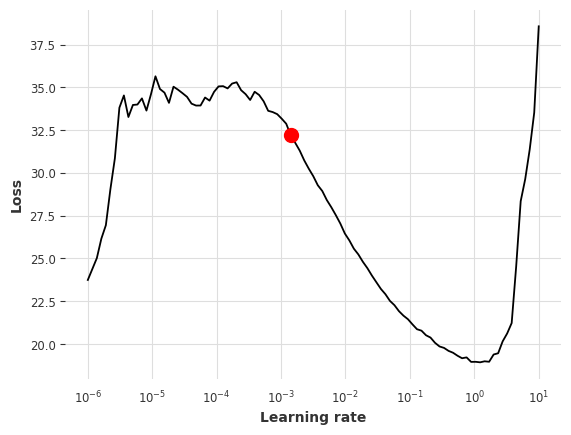

In [138]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [167]:
early_stop_callback = EarlyStopping(monitor='val_loss',
                                    min_delta=1e-4,
                                    patience=5,
                                    verbose=True,
                                    mode='min')
# log the learning rate
lr_logger = LearningRateMonitor() 

# logging results to tensorboard
logger = TensorBoardLogger('lightning_logs')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='cpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    # fast_dev_run=True # for checking that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training, 
    learning_rate=0.0018,
    hidden_size=160, 
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,
    loss=QuantileLoss(),
    optimizer='Ranger',
    log_interval=10, # logging every 10 batches
    reduce_on_plateau_patience=4)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 4560.6k


In [168]:
# fit network
trainer.fit(
    tft, 
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [169]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_8/checkpoints/epoch=15-step=6208.ckpt


In [ ]:
# import pickle

# # Hyperparameter tuning, overloads RAM on Google Colab
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path='optuna_test',
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 240),
#     hidden_continuous_size_range=(8, 240),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(accelerator='cpu',limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save results
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial_params)

In [170]:
# calculate mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(18.0600)

In [171]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
SMAPE()(predictions.output, predictions.y)

tensor(0.1175)

In [172]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
RMSE()(predictions.output, predictions.y)

tensor(40.4283)

In [173]:
# raw predictions: dictionary of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, 
                                   mode="raw", 
                                   return_x=True, 
                                   trainer_kwargs=dict(accelerator="cpu"))

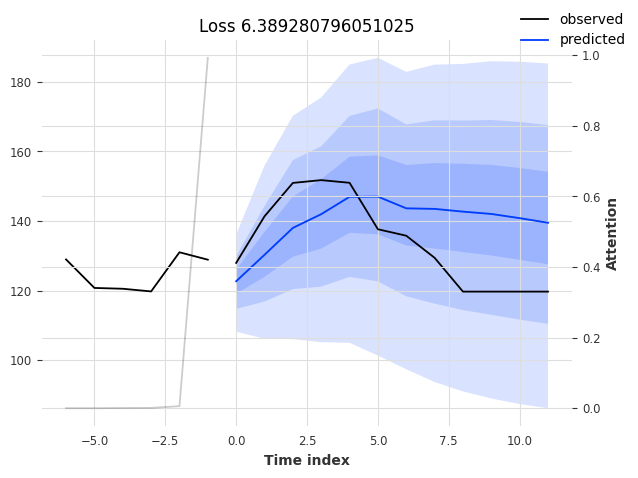

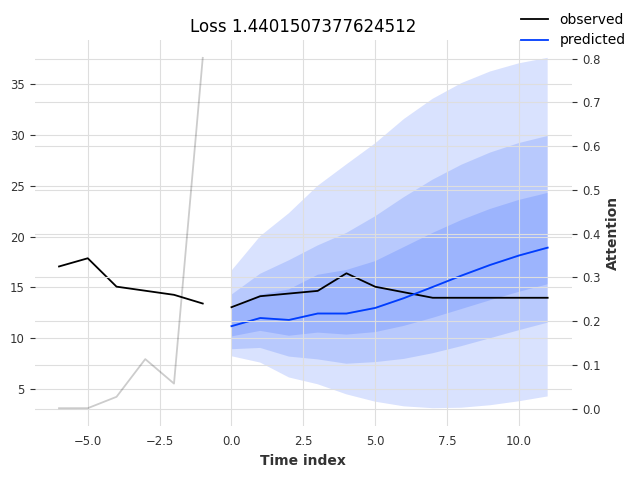

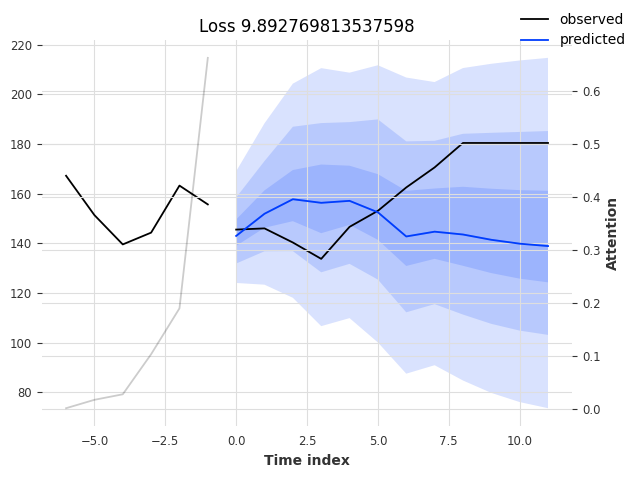

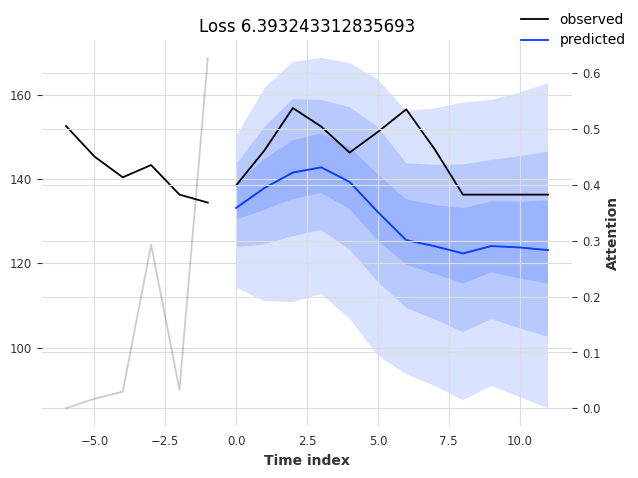

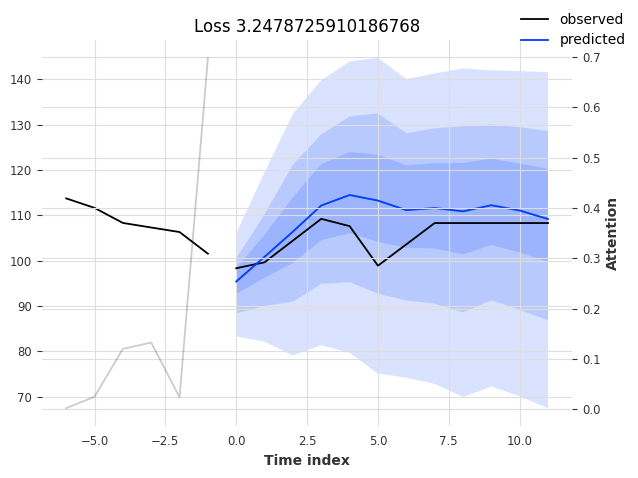

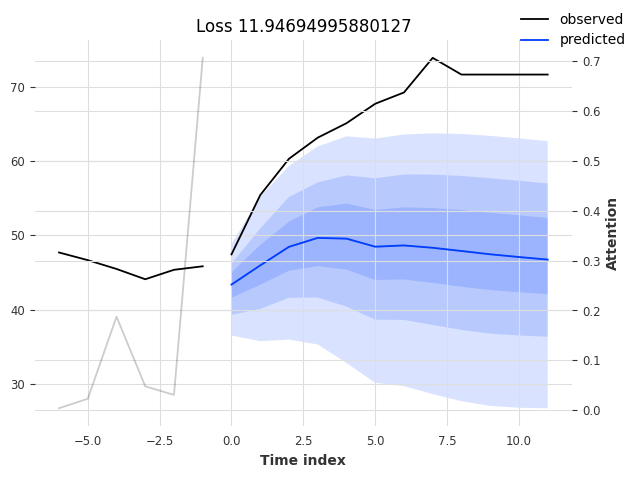

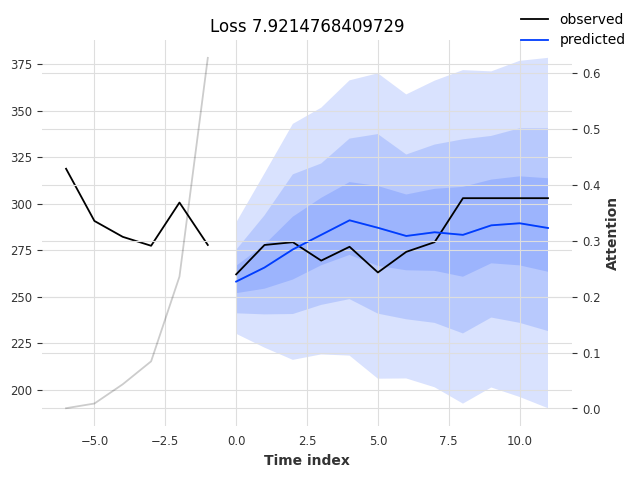

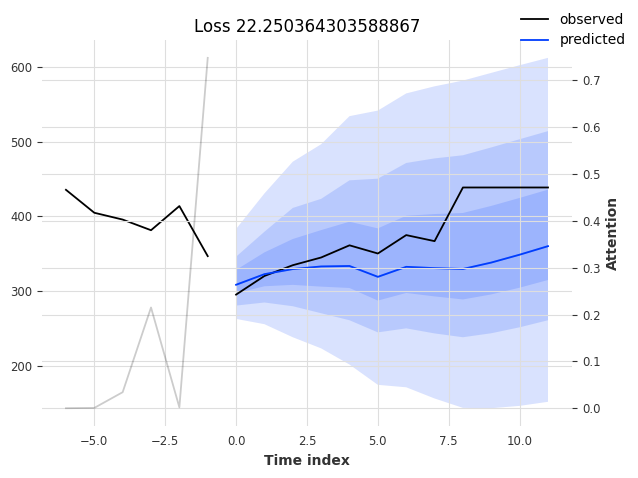

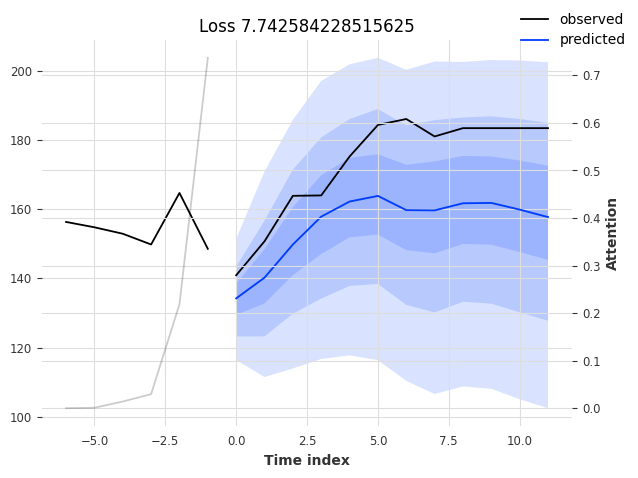

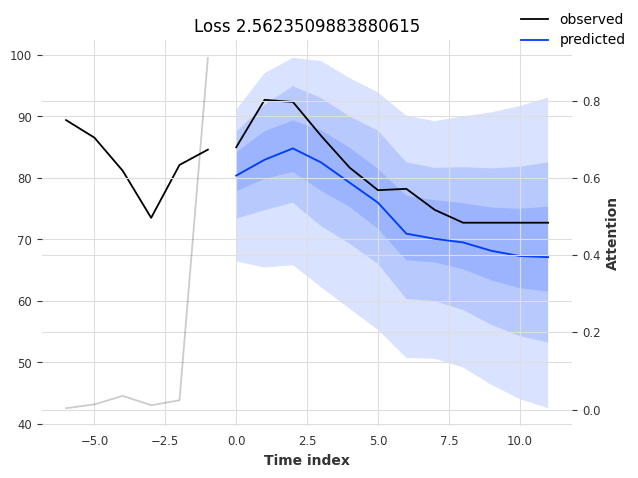

In [174]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'stock_price_center': <Figure size 1000x500 with 2 Axes>,
 'stock_price_scale': <Figure size 1000x500 with 2 Axes>,
 'Date': <Figure size 1000x500 with 2 Axes>,
 'Dividend': <Figure size 1000x500 with 2 Axes>,
 'Volume': <Figure size 1000x500 with 2 Axes>,
 'fed_funds_rate': <Figure size 1000x500 with 2 Axes>,
 'GDP': <Figure size 1000x500 with 2 Axes>,
 'debt_to_equity': <Figure size 1000x500 with 2 Axes>,
 'EPS': <Figure size 1000x500 with 2 Axes>,
 'return_on_equity': <Figure size 1000x500 with 2 Axes>,
 'quick ratio': <Figure size 1000x500 with 2 Axes>,
 'operating_ratio': <Figure size 1000x500 with 2 Axes>,
 'inventory_turnover': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'stock_price': <Figure size 1000x500 with 2 Axes>,
 'pos_ma': <Figure size 1000x500 with 2 Axes>,
 'neu_ma': <Figure size 1000x500 with 2 Axes>,
 'neg_ma': <Figure size 1000x500 with 2 Axes>}

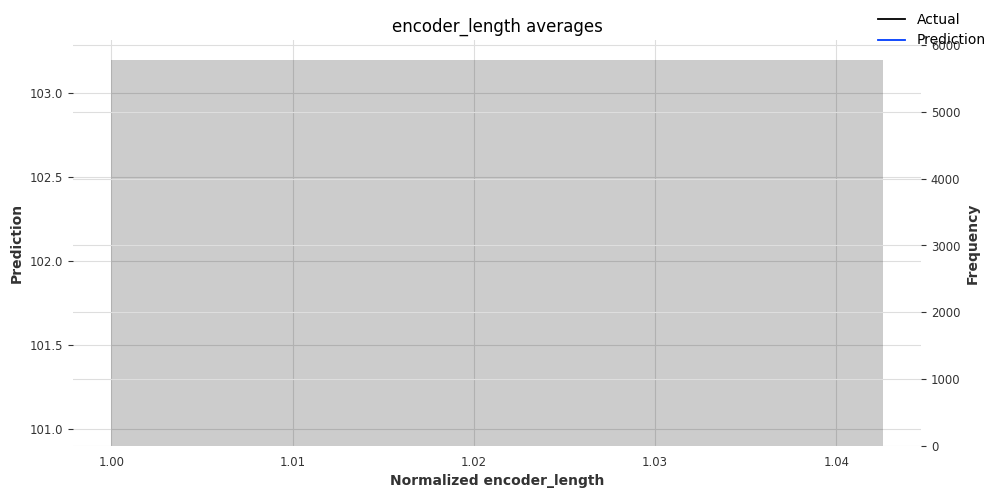

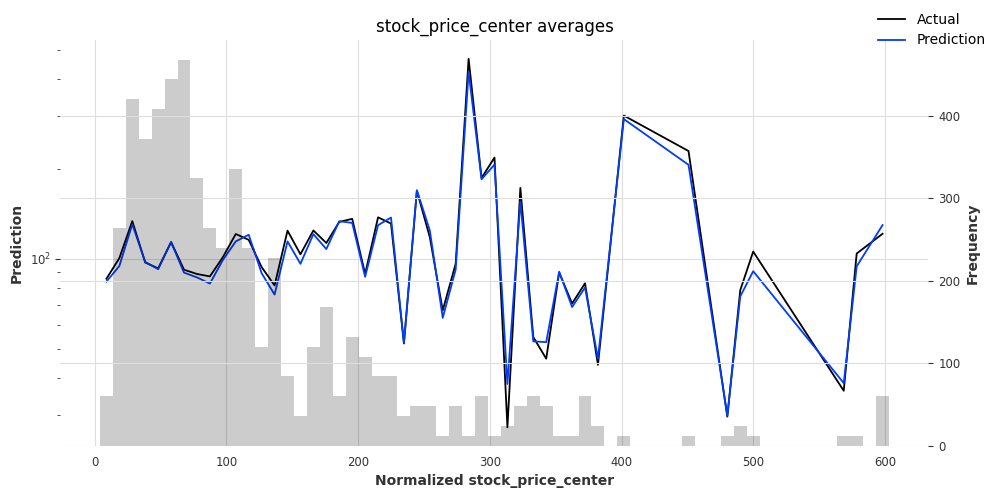

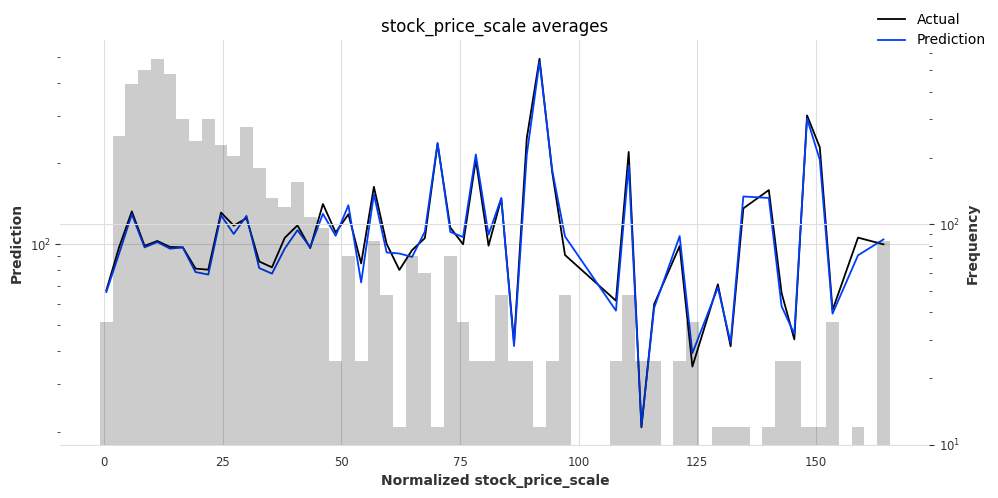

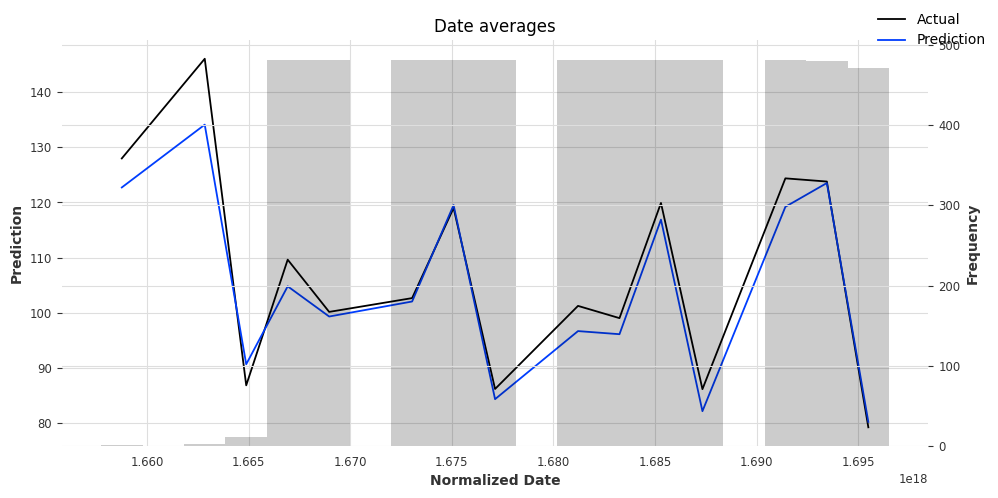

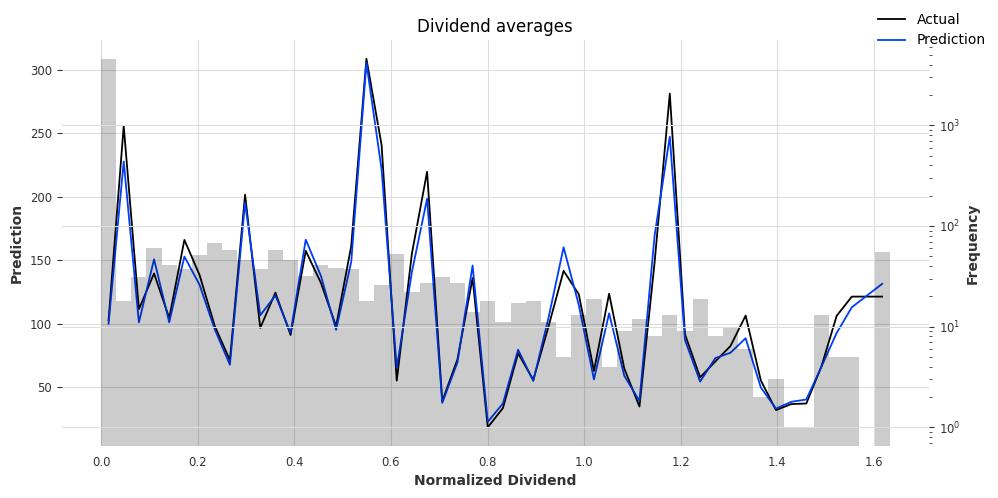

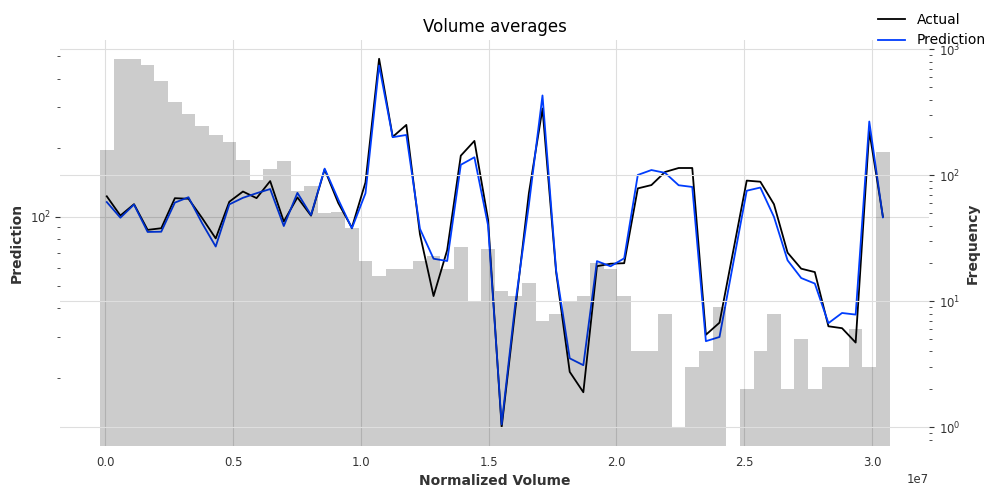

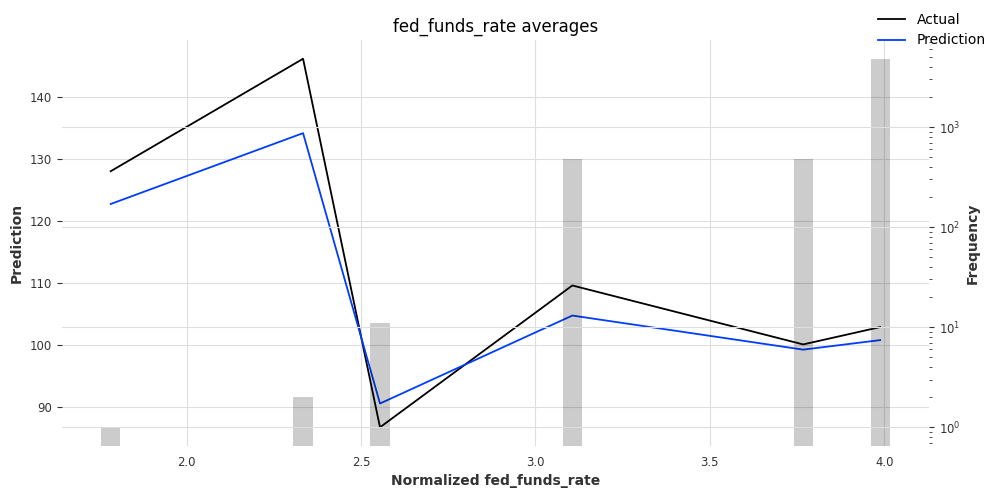

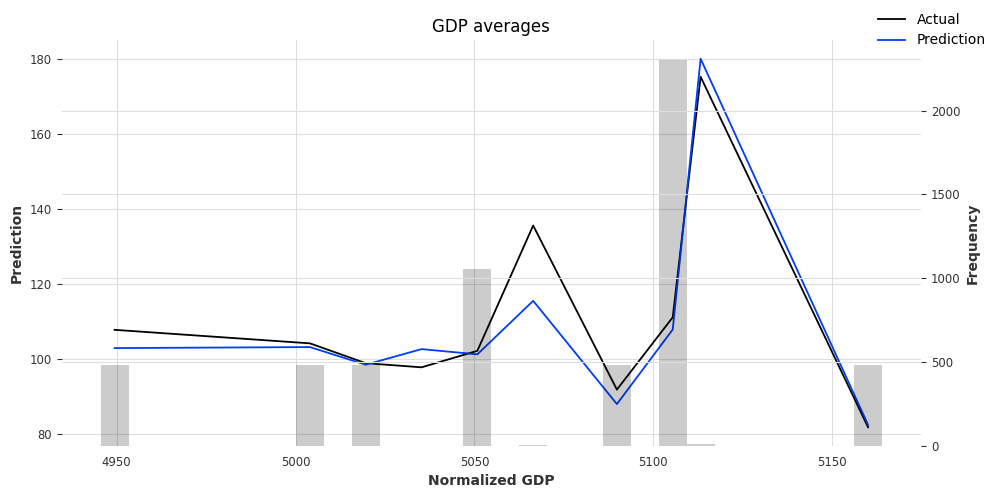

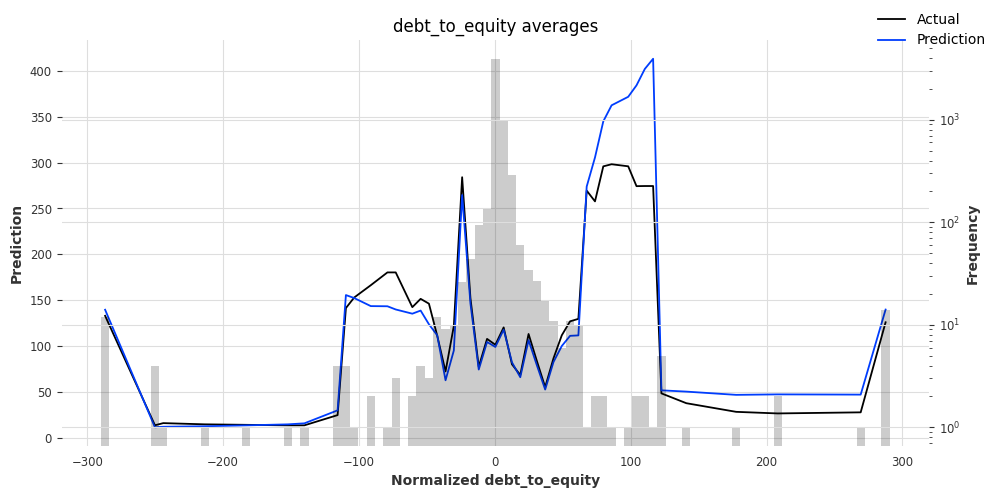

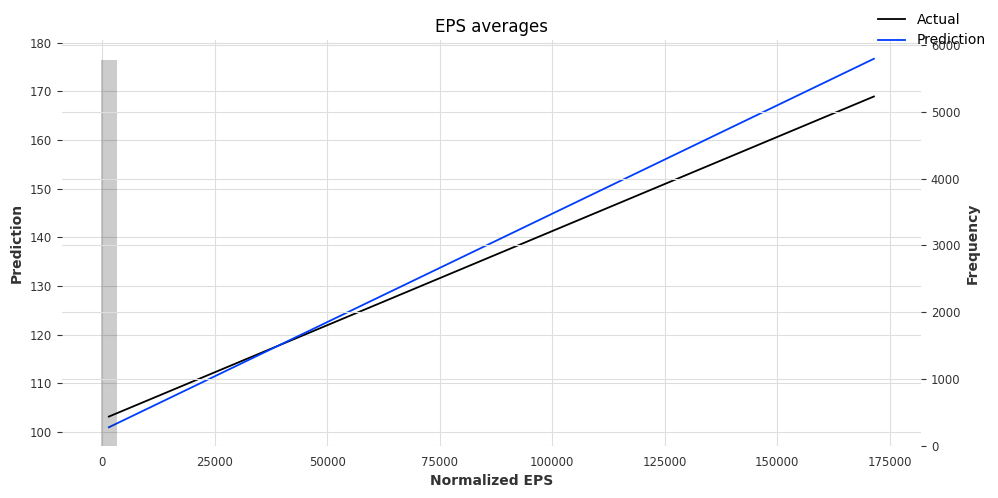

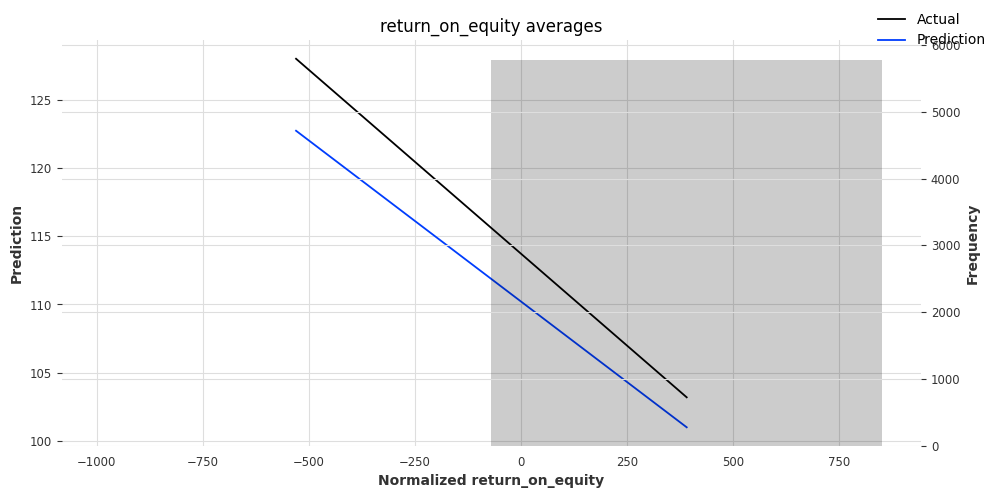

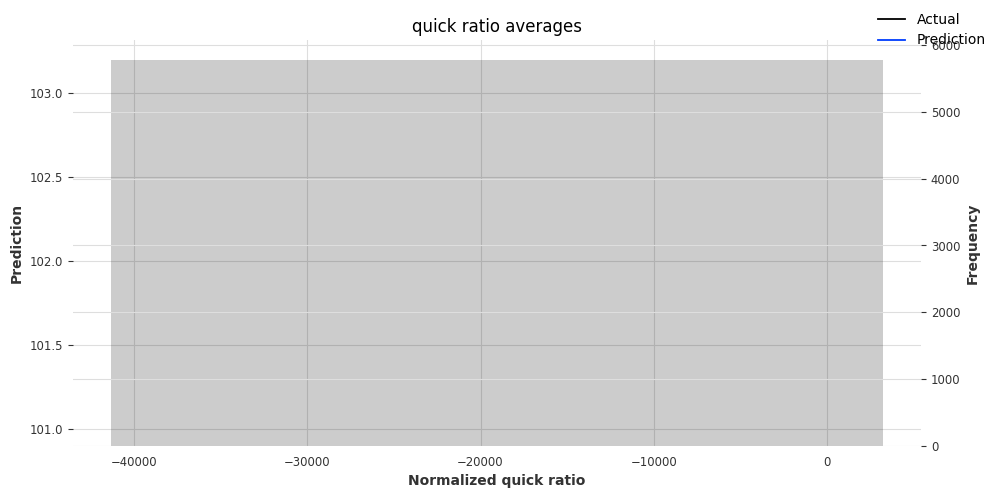

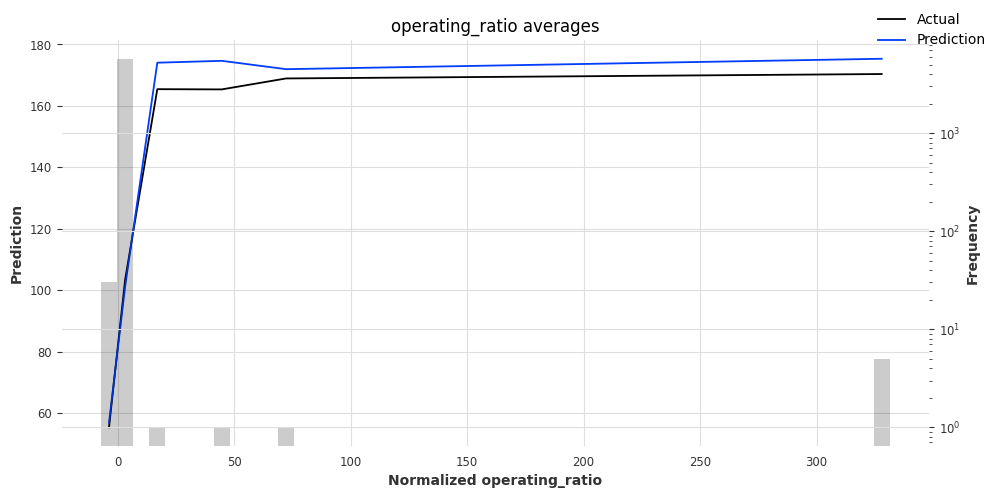

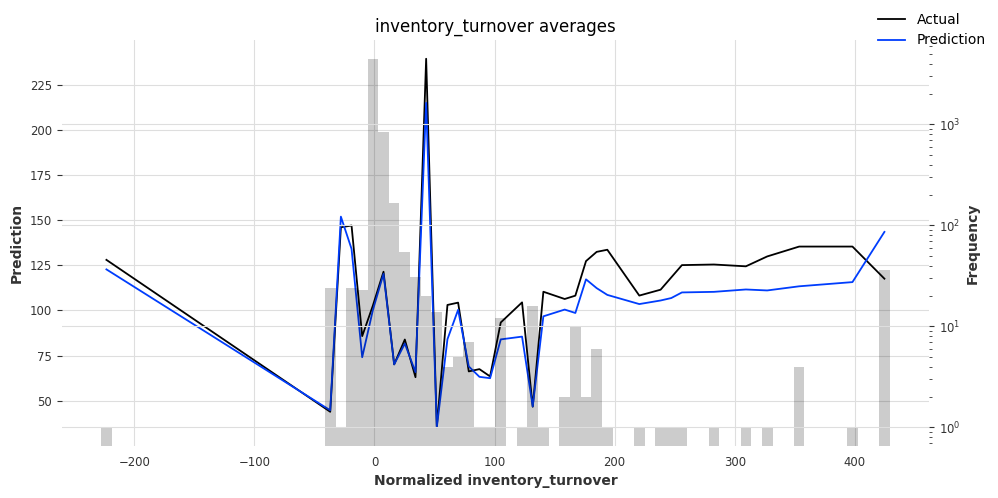

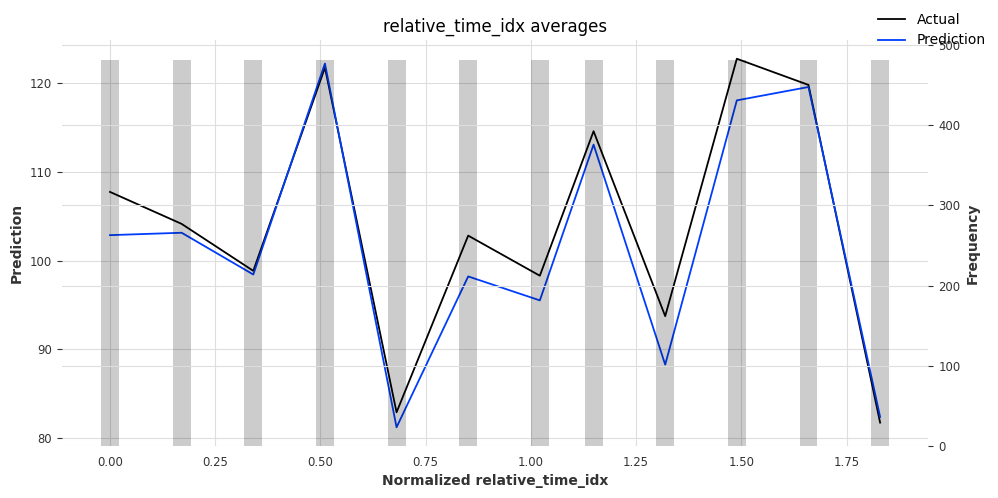

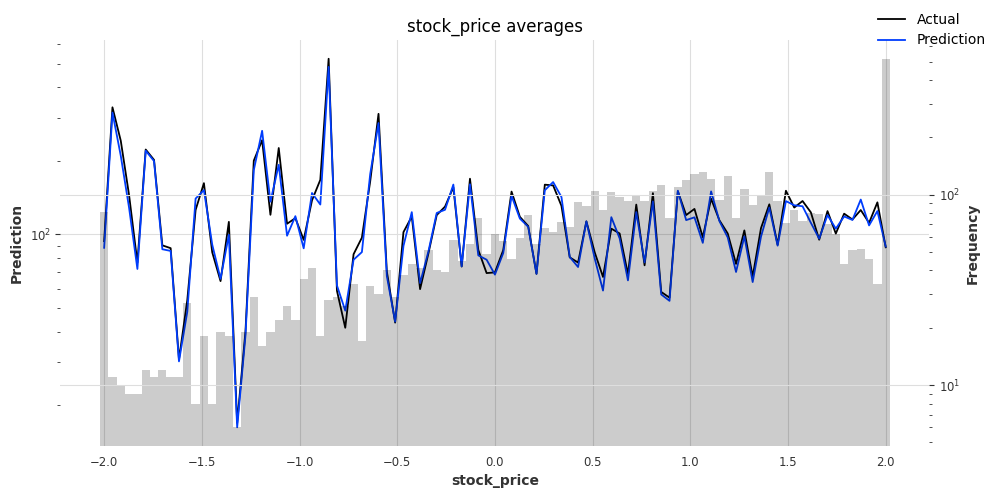

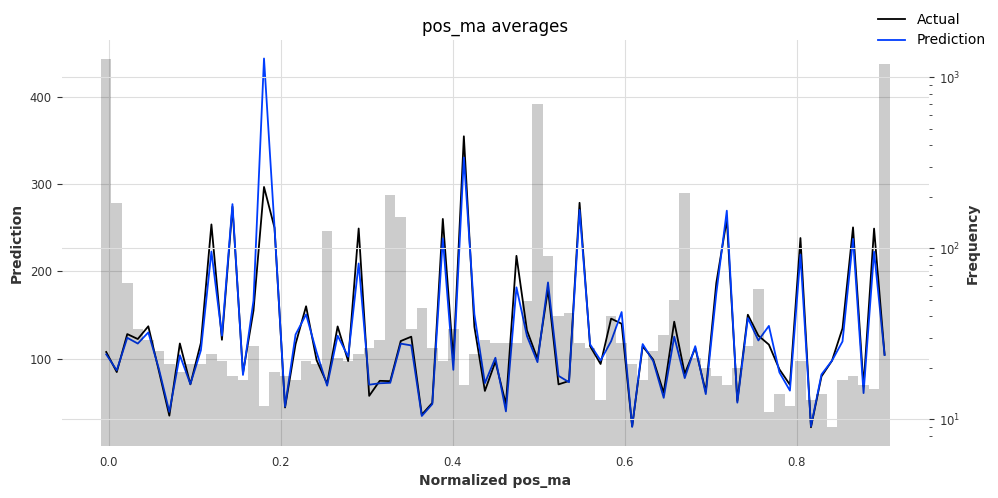

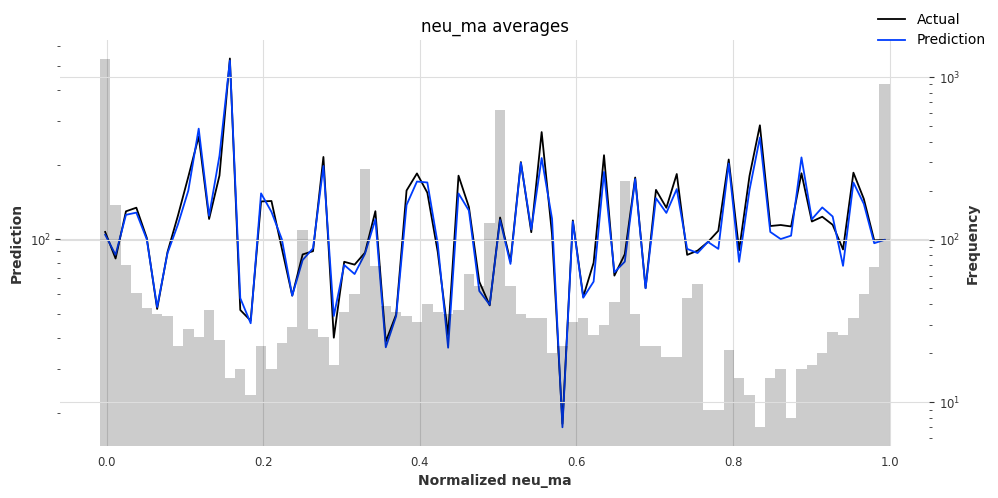

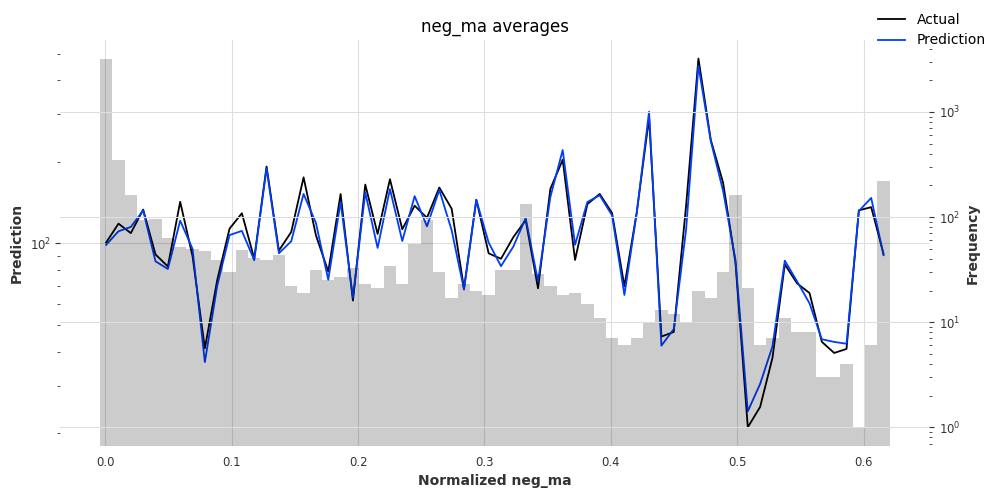

In [175]:
predictions = best_tft.predict(val_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [180]:
# Predict on selected data
best_tft.predict(
    training.filter(lambda x: (x.Tickers == "AAPL") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
    trainer_kwargs=dict(accelerator='cpu')
)

tensor([[[ 42.1078,  42.7683,  45.2080,  47.0367,  49.8188,  52.0754,  55.9170],
         [ 42.9294,  43.8289,  47.2405,  49.5578,  53.0591,  55.8050,  60.3611],
         [ 44.4582,  45.6980,  49.4920,  52.2740,  56.1399,  59.5594,  64.8949],
         [ 46.7971,  48.6059,  52.6761,  55.5749,  59.7921,  63.6969,  69.6265],
         [ 47.5155,  49.5608,  53.9736,  56.8826,  61.5286,  66.0001,  71.9495],
         [ 48.0010,  50.3263,  54.4419,  57.5309,  62.2879,  66.6301,  73.1328],
         [ 47.6180,  49.5056,  53.5641,  56.5149,  61.6232,  65.5466,  72.0016],
         [ 51.8694,  54.1716,  58.2321,  61.0439,  66.0695,  70.8475,  76.9506],
         [ 56.7385,  59.2131,  63.0070,  66.1097,  71.1500,  76.5107,  83.1471],
         [ 59.9601,  62.9221,  66.7749,  70.0442,  74.9756,  80.5309,  87.9590],
         [ 60.4707,  64.7980,  68.7838,  72.8058,  78.2570,  83.8865,  91.8945],
         [ 65.8461,  70.7932,  76.0330,  81.2987,  88.8695,  95.5438, 105.6583]]])

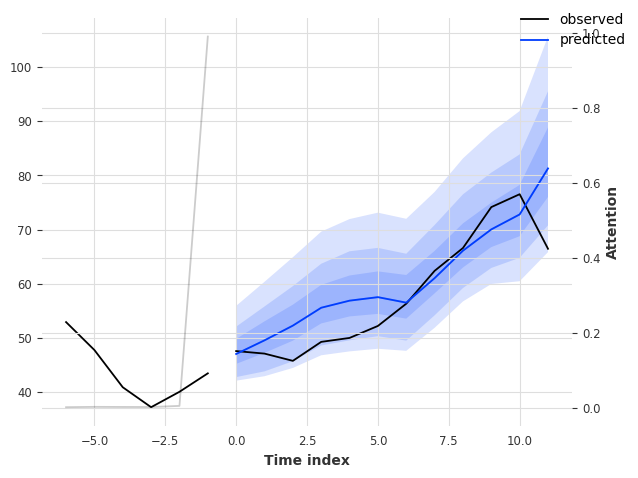

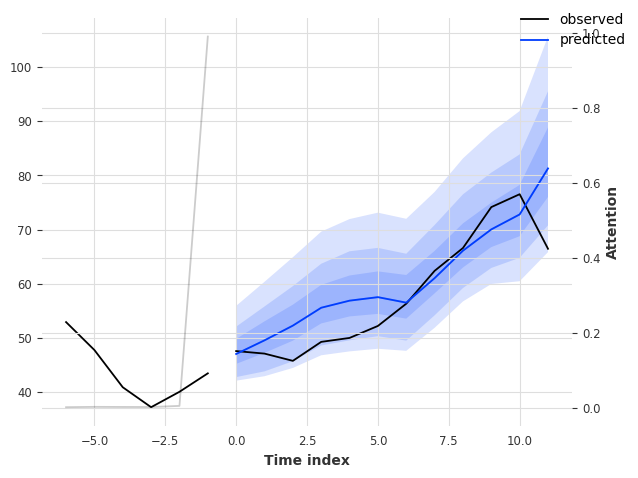

In [183]:
# Plot prediction
raw_prediction = best_tft.predict(
    training.filter(lambda x: (x.Tickers == "AAPL") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator='cpu')
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [207]:
# select last 6 months from data (max_encoder_length is 6)
encoder_data = df_pytorch[lambda x: x.Index > x.Index.max() - 12]

# select last known data point and create decoder data from it by repeating it and incrementing the month
last_data = df_pytorch[lambda x: x.Index == x.Index.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.Date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["Index"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month
decoder_data["Index"] += encoder_data["Index"].max() + 1 - decoder_data["Index"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [208]:
new_prediction_data

,Date,Dividend,Volume,stock_price,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma,ticker_encoded,Index,date,month
0,2022-10-31,0.00,3.851403e+07,13.057000,3.08,5157.178000,AAL,-10.173963,0.907008,-0.081955,0.661929,0.558064,2.120882,0.000001,4.999936e-01,5.000054e-01,1,57,NaT,NaN
1,2022-10-31,0.00,9.459152e+07,145.540596,3.08,5157.178000,AAPL,5.656863,1.496776,0.451949,0.859910,0.717944,10.227621,0.500000,4.999601e-01,3.986342e-05,2,57,NaT,NaN
2,2022-10-31,1.41,5.781940e+06,138.489687,3.08,5157.178000,ABBV,7.558852,1.952005,0.210613,0.834734,0.828718,1.432430,0.000059,4.999519e-01,4.999893e-01,3,57,NaT,NaN
3,2022-10-31,0.47,6.940340e+06,98.321206,3.08,5157.178000,ABT,1.036728,0.743526,0.036127,1.356569,0.859545,0.785160,0.023467,9.718559e-01,4.676753e-03,4,57,NaT,NaN
4,2022-10-31,0.00,5.481613e+06,47.441667,3.08,5157.178000,ACGL,2.853001,0.812091,0.024490,0.720869,0.354042,0.000000,0.726968,2.337701e-02,2.496553e-01,5,57,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8209,2023-09-30,0.00,2.114983e+06,133.590376,5.08,5105.025000,YUM,-1.693220,1.487544,-0.049550,0.721587,0.427386,0.938914,0.008204,4.912204e-01,5.005759e-01,477,69,2024-03-01,3
8210,2023-09-30,0.00,1.614090e+06,135.349948,5.08,5105.025000,ZBH,0.720673,1.004794,0.016942,0.945561,0.834571,0.230908,0.499998,5.000007e-01,1.404991e-06,478,69,2024-03-01,3
8211,2023-09-30,0.00,3.709700e+05,274.414666,5.08,5053.623333,ZBRA,1.491979,2.802807,0.048128,0.502260,0.854987,0.732639,0.999969,2.603792e-05,5.176677e-06,479,69,2024-03-01,3
8212,2023-09-30,0.00,5.042810e+06,28.125514,5.08,5105.025000,ZION,15.511452,1.181283,0.033125,0.458553,0.388889,-17.000000,1.000000,2.596820e-07,6.590589e-08,480,69,2024-03-01,3


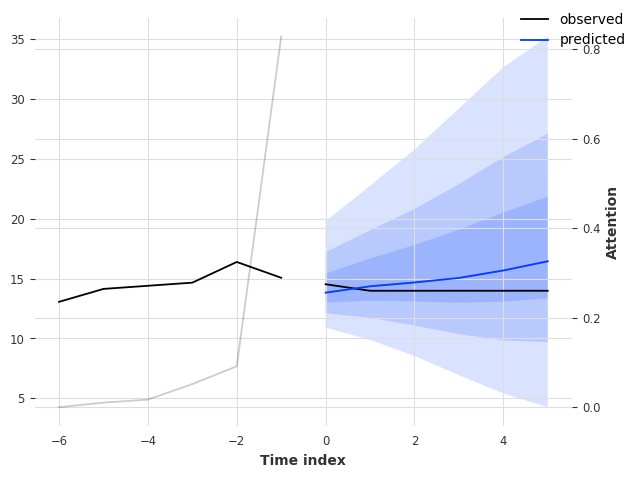

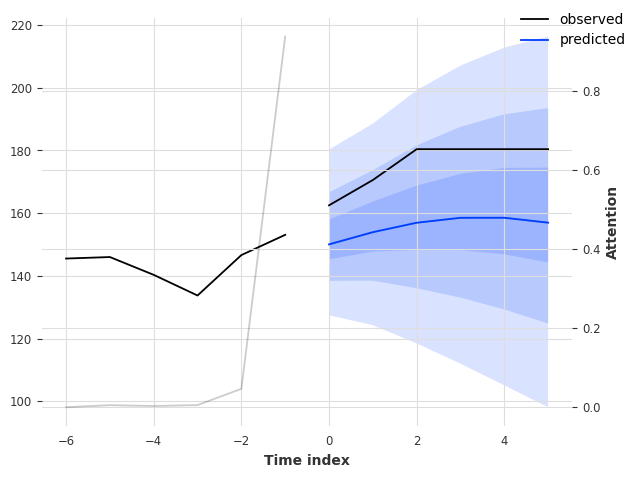

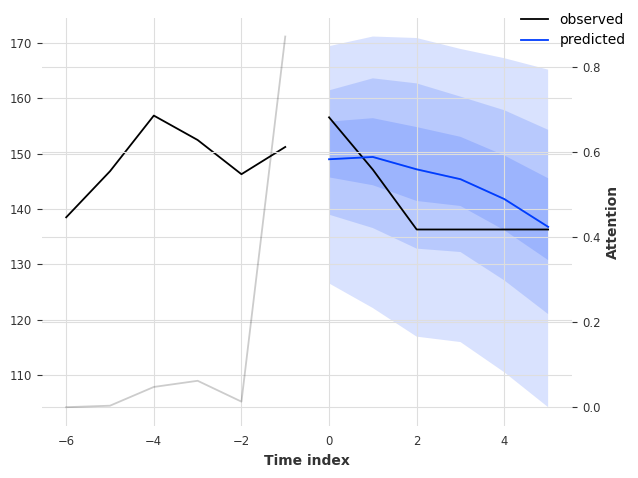

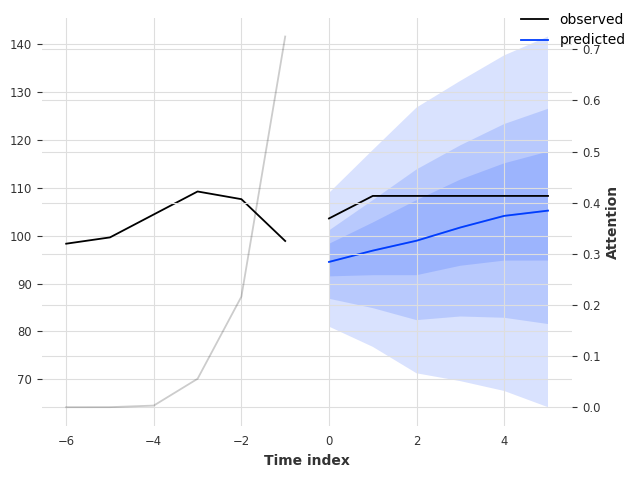

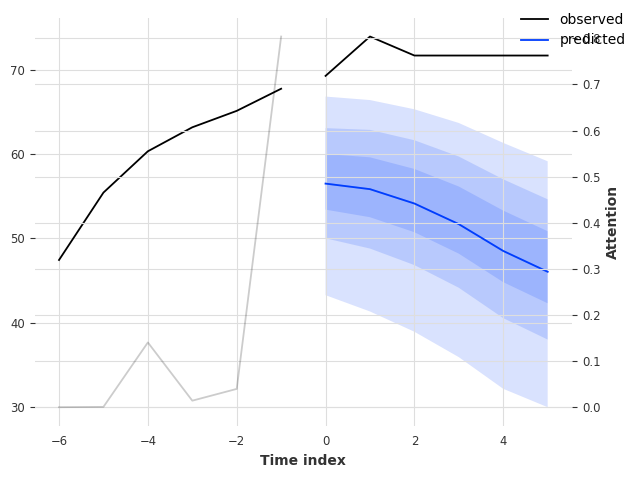

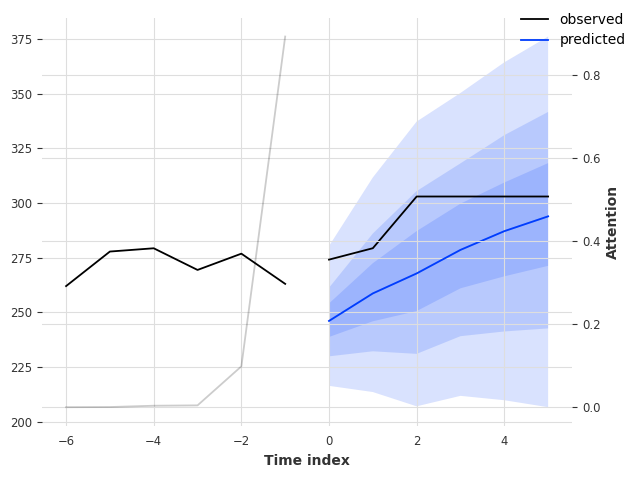

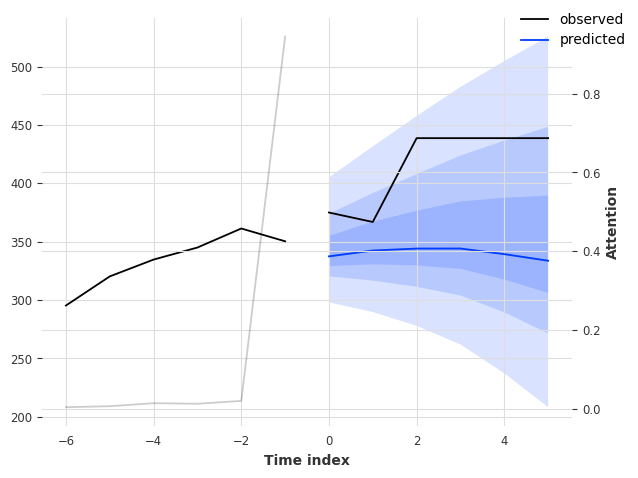

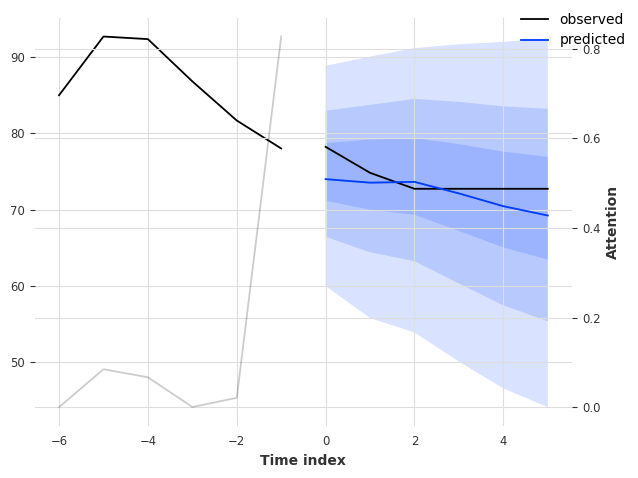

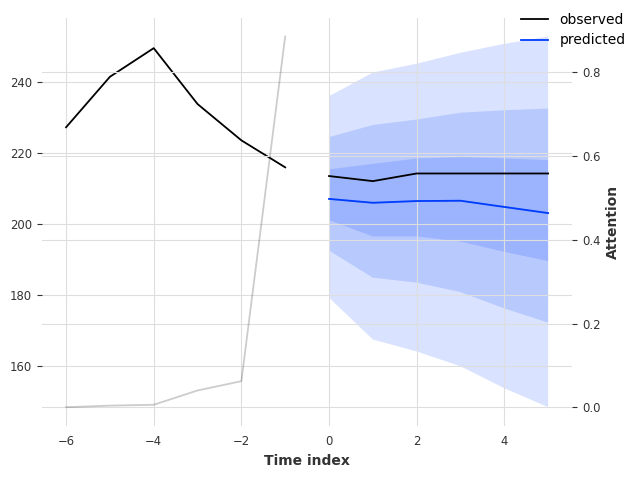

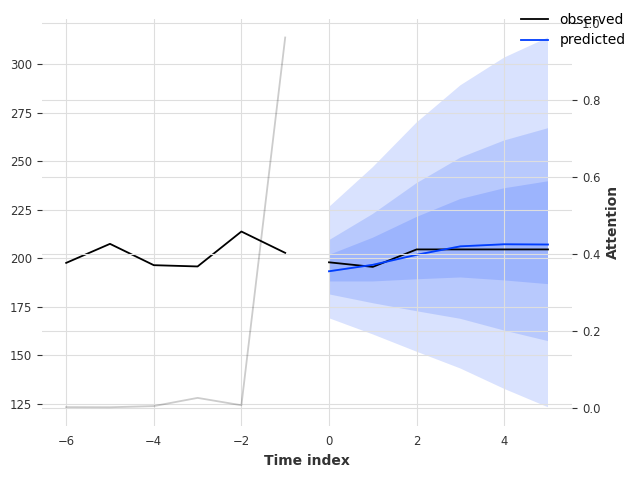

In [209]:
new_raw_predictions = best_tft.predict(encoder_data,
                                       mode="raw",
                                       return_x=True,
                                       trainer_kwargs=dict(accelerator='cpu'))
# Plot 10 examples
for idx in range(10):
    best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output,
                             idx=idx, show_future_observed=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x600 with 1 Axes>,
 'decoder_variables': <Figure size 700x500 with 1 Axes>}

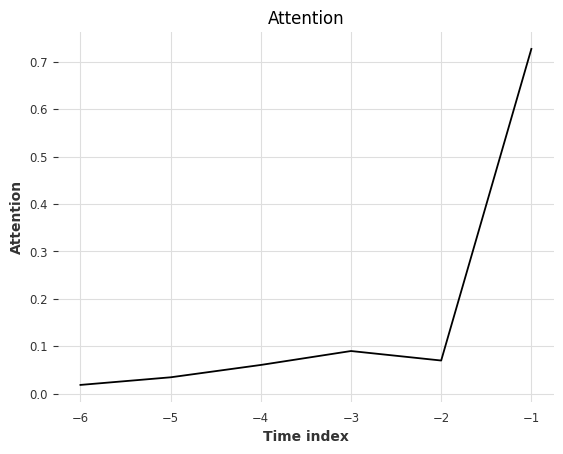

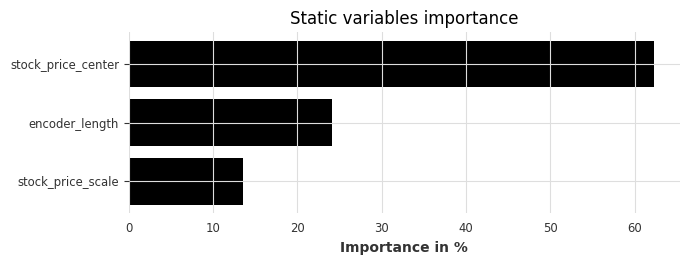

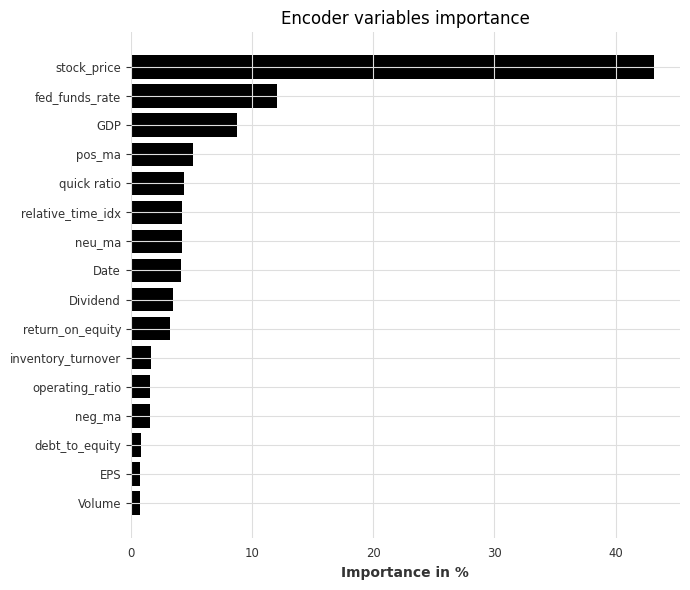

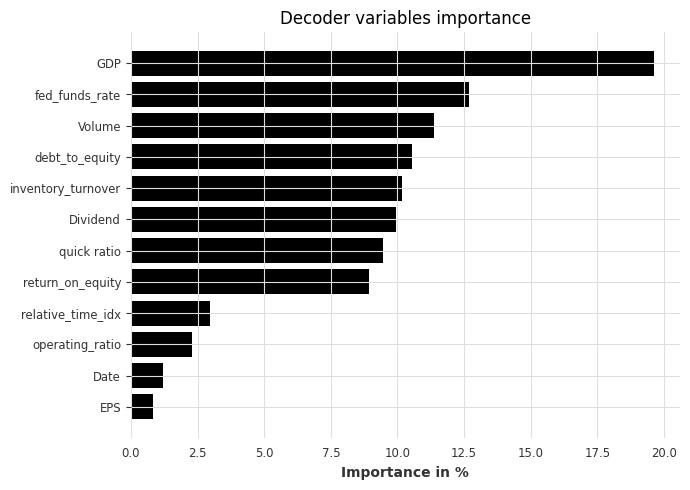

In [210]:
# Variable importance
interpretation = best_tft.interpret_output(raw_predictions.output, reduction='sum')
best_tft.plot_interpretation(interpretation)

## N-HiTS

In [227]:
!pip install cpflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for backports.functools-lru-cache>=1.6.1 from https://files.pythonhosted.org/packages/08/e3/1387bd1c9aa95e354064ee29b8a1dfd3e795b066cc869af8f8d6b70ae4aa/backports.functools_lru_cache-1.6.6-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 3.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for h5py from https://files.pythonhosted.org/packages/4

In [228]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE, MQF2DistributionLoss, QuantileLoss

from cpflows.flows import ActNorm
from cpflows.icnn import PICNN

In [254]:
# create dataset and dataloaders
max_encoder_length = 6
max_prediction_length = 6

training_cutoff = df_pytorch["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

n_training = TimeSeriesDataSet(
    df_pytorch[lambda x:x.time_idx <= training_cutoff], 
    group_ids=['Tickers'],
    target='stock_price',
    time_idx='time_idx',
    max_encoder_length=6,
    max_prediction_length=6,
    static_categoricals=['Tickers'],
    time_varying_known_reals=["Date", "Dividend", 'Volume', 'fed_funds_rate', 'GDP',
                               'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
                               'operating_ratio', 'inventory_turnover'],
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["stock_price", 'pos_ma','neu_ma', 'neg_ma'],
    target_normalizer=GroupNormalizer(
        groups=['Tickers'], transformation="softplus"
    ),
    add_relative_time_idx=False)

n_validation = TimeSeriesDataSet.from_dataset(n_training, df_pytorch, min_prediction_idx=training_cutoff + 1)
batch_size = 128
n_train_dataloader = n_training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
n_val_dataloader = n_validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [250]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

tensor(0.1263)

In [251]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
RMSE()(baseline_predictions.output, baseline_predictions.y)

tensor(76.0460)

In [252]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(22.7062)

In [256]:
pl.seed_everything(43)
trainer = pl.Trainer(
    accelerator='cpu',
    gradient_clip_val=0.1)

net = NHiTS.from_dataset(
    n_training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW")

In [241]:
# find optimal learning rate
res = Tuner(trainer).lr_find(
    net, 
    train_dataloaders=n_train_dataloader,
    val_dataloaders=n_val_dataloader,
    min_lr=1e-3)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (436x216 and 198x64)

In [237]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    n_training,
    learning_rate=5e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

trainer.fit(
    net,
    train_dataloaders=n_train_dataloader,
    val_dataloaders=n_val_dataloader,
)

Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x216 and 198x64)

**------------------------------------------------------------------------**

In [42]:
train_idx = round((len(df) * 0.80))
train_idx

26331

In [43]:
train = df.iloc[:train_idx]
test = df.iloc[train_idx:]

In [44]:
# Count rows for each Ticker in training set
ticker_counts = train.groupby('Tickers').size().reset_index(name='Row_Count')
ticker_counts.Row_Count.unique()

array([55, 56, 51, 54, 38, 15, 47, 49, 53,  4,  5, 50, 23, 37, 28])

In [45]:
symbol_row_counts = train['Tickers'].value_counts()

# Filter symbols with row counts greater than or equal to 6
symbols_to_keep = symbol_row_counts[symbol_row_counts >= 6].index.tolist()

# Filter the 'train' DataFrame to keep only the symbols with row counts >= 6
filtered_train = train[train['Tickers'].isin(symbols_to_keep)]

filtered_train.shape

(26322, 17)

**Note: to check tickers in training set, remove from test set**

In [18]:
# Split training set into train and validation
filtered_train_idx = round((len(filtered_train)*0.75))
filtered_train_idx

19742

In [20]:
train = filtered_train.iloc[:filtered_train_idx]
val = filtered_train.iloc[filtered_train_idx:]

In [ ]:
# Normalize time series 
scaler = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

In [54]:
# convert Date column into DateTime and set as integer index in chronological order
df1 = df.copy()
df1['Date'] = pd.to_datetime(df1['Date'])

In [57]:
df1['Index'] = df1.groupby('Tickers').cumcount()
df1

,Date,Dividend,Volume,stock_price,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma,ticker_encoded,Index
0,2018-01-31,0.00,5.315047e+06,51.919825,1.41,4500.182000,AAL,-134.253165,0.807713,-0.941772,0.484585,0.476713,1.930838,0.285655,5.198588e-01,1.944860e-01,1,0
1,2018-01-31,0.00,1.795523e+08,40.275178,1.41,4500.182000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.222114,6.974815e-01,8.040471e-02,2,0
2,2018-01-31,0.71,7.794467e+06,87.747239,1.41,4500.182000,ABBV,-23.651147,1.818001,-0.940431,1.083967,0.657965,1.027436,0.351660,3.990092e-01,2.493303e-01,3,0
3,2018-01-31,0.28,7.860137e+06,54.655791,1.41,4500.182000,ABT,1.333073,0.319962,0.018336,1.128287,0.829424,0.837345,0.323488,5.800269e-01,9.648529e-02,4,0
4,2018-01-31,0.00,1.614810e+06,29.889667,1.41,4500.182000,ACGL,2.331811,0.564373,0.024308,0.679544,0.278000,0.000000,0.000003,1.541489e-05,9.999820e-01,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32909,2023-09-30,0.00,2.114983e+06,133.590376,5.08,5105.025000,YUM,-1.693220,1.487544,-0.049550,0.721587,0.427386,0.938914,0.008204,4.912204e-01,5.005759e-01,477,68
32910,2023-09-30,0.00,1.614090e+06,135.349948,5.08,5105.025000,ZBH,0.720673,1.004794,0.016942,0.945561,0.834571,0.230908,0.499998,5.000007e-01,1.404991e-06,478,68
32911,2023-09-30,0.00,3.709700e+05,274.414666,5.08,5053.623333,ZBRA,1.491979,2.802807,0.048128,0.502260,0.854987,0.732639,0.999969,2.603792e-05,5.176677e-06,479,68
32912,2023-09-30,0.00,5.042810e+06,28.125514,5.08,5105.025000,ZION,15.511452,1.181283,0.033125,0.458553,0.388889,-17.000000,1.000000,2.596820e-07,6.590589e-08,480,68


In [59]:
df2 = df1.copy()
df2.set_index('Index', inplace=True)
df2

,Date,Dividend,Volume,stock_price,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma,ticker_encoded
Index,,,,,,,,,,,,,,,,,
0,2018-01-31,0.00,5.315047e+06,51.919825,1.41,4500.182000,AAL,-134.253165,0.807713,-0.941772,0.484585,0.476713,1.930838,0.285655,5.198588e-01,1.944860e-01,1
0,2018-01-31,0.00,1.795523e+08,40.275178,1.41,4500.182000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.222114,6.974815e-01,8.040471e-02,2
0,2018-01-31,0.71,7.794467e+06,87.747239,1.41,4500.182000,ABBV,-23.651147,1.818001,-0.940431,1.083967,0.657965,1.027436,0.351660,3.990092e-01,2.493303e-01,3
0,2018-01-31,0.28,7.860137e+06,54.655791,1.41,4500.182000,ABT,1.333073,0.319962,0.018336,1.128287,0.829424,0.837345,0.323488,5.800269e-01,9.648529e-02,4
0,2018-01-31,0.00,1.614810e+06,29.889667,1.41,4500.182000,ACGL,2.331811,0.564373,0.024308,0.679544,0.278000,0.000000,0.000003,1.541489e-05,9.999820e-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2023-09-30,0.00,2.114983e+06,133.590376,5.08,5105.025000,YUM,-1.693220,1.487544,-0.049550,0.721587,0.427386,0.938914,0.008204,4.912204e-01,5.005759e-01,477
68,2023-09-30,0.00,1.614090e+06,135.349948,5.08,5105.025000,ZBH,0.720673,1.004794,0.016942,0.945561,0.834571,0.230908,0.499998,5.000007e-01,1.404991e-06,478
68,2023-09-30,0.00,3.709700e+05,274.414666,5.08,5053.623333,ZBRA,1.491979,2.802807,0.048128,0.502260,0.854987,0.732639,0.999969,2.603792e-05,5.176677e-06,479


**Later on, when converting integer  index back to datetime**

In [ ]:
# # Convert integer index back to datetime
# integer_index = 5  # Arbitrary integer index
# corresponding_date = df[df['integer_index'] == integer_index].index[0]
# print(f"Integer Index {integer_index} corresponds to Date: {corresponding_date}")

# # Accessing data by datetime
# specific_date = pd.Timestamp('2021-05-01')  # Arbitrary date
# value_at_date = df.loc[specific_date, 'value']
# print(f"Value at {specific_date}: {value_at_date}")

In [62]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df2['stock_price'])

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

ValueError: Could not convert integer index to a pd.RangeIndex. Found non-unique step sizes/frequencies: {0, 1}. If any of those is the actual frequency, try passing it with fill_missing_dates=True and freq=your_frequency.

In [257]:
!git add huiye-model.ipynb
!git commit -m "TFT model"
!git push or

On branch huiye
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   huiye-model.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../.DS_Store
	../.python-version
	.lr_find_23d11079-7e72-4140-aef3-f307361a6931.ckpt
	.lr_find_3fabda91-ccf0-4bb5-ac85-8f75351d4fba.ckpt
	.lr_find_cc7ea1f3-572e-496e-9d91-d156b2c86d66.ckpt
	.lr_find_f121e07a-8013-407f-9bcd-6198e3fc97c5.ckpt
	lightning_logs/
	optuna_test/
	../raw_data/.DS_Store
	../raw_data/00/
	../raw_data/80_500_tickers.csv
	../raw_data/GDP_interpolated.csv
	../raw_data/NLP_monthly_2209019.csv
	../raw_data/SP500_bal_income.csv
	../raw_data/SP500_balance_sheet.csv
	../raw_data/SP500_income_statement.csv
	../raw_data/adj_close.csv
	../raw_data/close.csv
	../raw_data/dividend.csv
	../raw_data/feature_matrix_with_si.csv
	../raw_data/feature_matrix_wo_si.csv
	../raw_data/features.csv